# PM10 Experiment
This notebook contains the code for the semi-synthetic data experiment that I conducted on the PM10 dataset.

In [1]:
import sys 
sys.path.append('..')

import cox
from cox.store import Store
from cox.utils import Parameters
from cox.readers import CollectionReader
import torch as ch
from torch import Tensor
import torch.linalg as LA
from torch.utils.data import DataLoader
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
import math
from sklearn.metrics import r2_score
import os
import datetime
from sklearn.datasets import load_boston
import matplotlib.patches as mpatches
from mpl_toolkits.mplot3d import Axes3D 
import subprocess
import IPython
import matplotlib.patches as mpatches

from delphi import oracle 
from delphi.stats.linear_regression import TruncatedRegression

TABLE_NAME = 'logs'
COMMAND = 'RScript'

# commands and arguments
COMMAND = 'Rscript'
PATH2SCRIPT = './truncreg.R'
TMP_FILE = 'tmp.csv'
RESULT_FILE = 'result.csv'

# mean squared error loss
mse_loss = ch.nn.MSELoss()

In [2]:
args = Parameters({
    "bs": 100,
    "trials": 10,
    "steps": 2500,
    "table_name": 'results', 
    'tol': 1e-2,
    'n': 100,
    'lr': 1e-1,
    'step_lr': 100, 
    'step_lr_gamma': .9,
    'attempts': 3, 
    'val': .2,
    "out_dir": '/Users/patroklos/Desktop/pm10_bs_100', # where to write results to
    "dataset": './pm10.csv',
    "exp": 'RunAgain' # experiment name
})

# Import Dataset into Notebook
The fist thing that we nned to do is import the dataset. To do this, you can either provide the path to your dataset, including the filename to the $\textit{dataset}$ key of the args dictionary.

In [3]:
df = pd.read_csv(args.dataset)
df.head()

,pm10_concentration,cars_per_hour,temperature_at_2m,wind_speed,temperature_diff_2m_25m,wind_direction,hour_of_day,day
0,3.66356,7.74414,-4.4,4.2,0.0,18.0,19,116
1,3.04452,8.03398,-5.7,4.8,-0.3,69.1,9,506
2,3.71357,4.70048,-13.5,4.3,0.2,80.0,3,95
3,2.94444,7.52510,1.4,3.0,0.1,177.0,22,161
4,4.06044,7.76260,4.1,5.6,1.1,287.0,7,80


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
pm10_concentration         500 non-null float64
cars_per_hour              500 non-null float64
temperature_at_2m          500 non-null float64
wind_speed                 500 non-null float64
temperature_diff_2m_25m    500 non-null float64
wind_direction             500 non-null float64
hour_of_day                500 non-null int64
day                        500 non-null int64
dtypes: float64(6), int64(2)
memory usage: 31.4 KB


# Data Exploration
For this regression task, we want to predict the PM10 concentratioin in the air at the specific time of a day. PM concentration is measure of the particulate matter in the air that has a diameter of less that 10 micrometers. And particulate matter is everything in the air that is not a gas and therefore consists of a huge variety of chemical compounds and materials. Now, the first thing that we want to do after extracting our data from csv file, is check whether our dependent variable is normally distibuted. When we plot our histogram, we see that in fact is normally distributed.

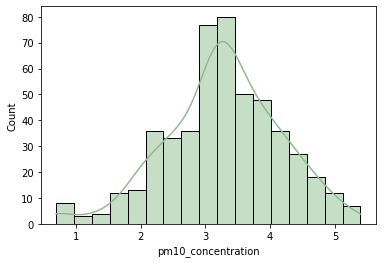

In [11]:
sns.histplot(data=df, x='pm10_concentration', kde=True, color="darkseagreen")

Now, that we know that our dependent variable is normally distributed, the next step is extracting the features that we want to use for our inputs. To do this, we want to determine which independent variables have a correlation with the PM10 concentration. The first thing that we do is create a correlation matrix to see the Pearson correlation's that the independent variables have with respect to one another.

In [12]:
corr_matrix = df.corr()
corr_matrix

,pm10_concentration,cars_per_hour,temperature_at_2m,wind_speed,temperature_diff_2m_25m,wind_direction,hour_of_day,day
pm10_concentration,1.000000,0.355607,0.046287,-0.145214,-0.071561,0.016439,0.213435,0.045819
cars_per_hour,0.355607,1.000000,0.257275,0.186776,-0.346744,0.008911,0.555063,-0.002579
temperature_at_2m,0.046287,0.257275,1.000000,0.213626,-0.358029,0.321139,0.119237,0.161279
wind_speed,-0.145214,0.186776,0.213626,1.000000,-0.272142,-0.091684,0.032277,0.040603
temperature_diff_2m_25m,-0.071561,-0.346744,-0.358029,-0.272142,1.000000,-0.041507,-0.069560,-0.142914
wind_direction,0.016439,0.008911,0.321139,-0.091684,-0.041507,1.000000,0.036591,0.044858
hour_of_day,0.213435,0.555063,0.119237,0.032277,-0.069560,0.036591,1.000000,-0.049054
day,0.045819,-0.002579,0.161279,0.040603,-0.142914,0.044858,-0.049054,1.000000


After examining the correlation matrix, we notice that the features taht are the most correlated to the PM10 concentration are cars per hour and wind speed. Further, we see that windspeed and cars per hour have a correlation of .186776, which is very small. Implying that there there are no multicollinearity issue with our regression setup. We now create a pairplot to further evaluate relationships between the features.

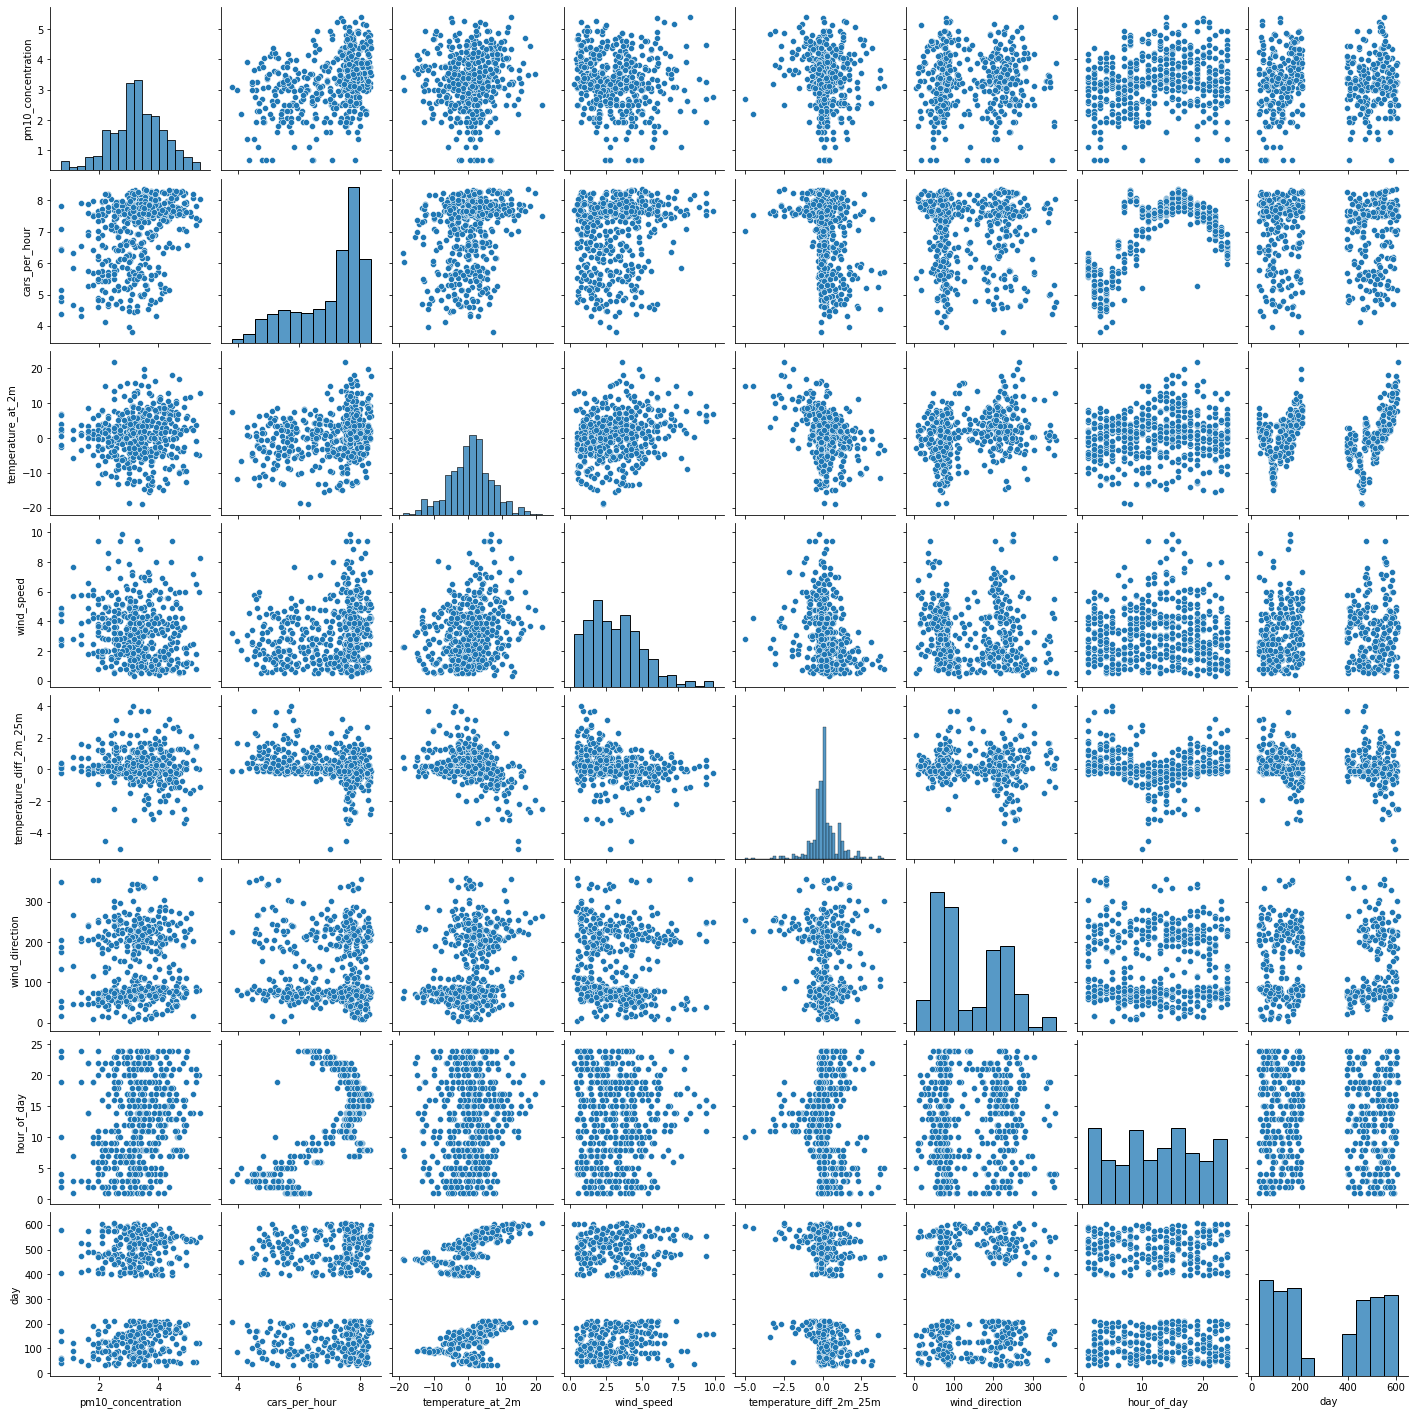

In [13]:
sns.pairplot(df)

After looking at the pairplot, we are pretty set on our features for setting up our untruncated regression. We will set up our untruncated regression with $\textit{cars_per_hour}$ and $\textit{wind_speed}$ as our input features, and $\textit{pm10_concentration}$ as our prediction task. We now look at the ground-truth, and look at some of its metrics.

When we look at the $R^2$ of our original regression, we notice that is not that high $.17$. However, we only need our residuals to be normally distributed for our framework to work.

R^2:  0.1728636862809666
ground-truth variance:  0.6504841446876526


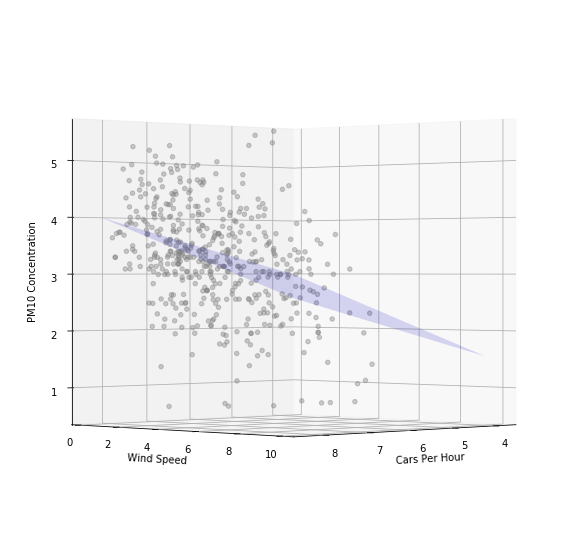

In [5]:
X, y = Tensor(df[['cars_per_hour', 'wind_speed']].to_numpy()), Tensor(df['pm10_concentration'].to_numpy()[...,None])
gt_ols = LinearRegression()
gt_ols.fit(X, y)
score = gt_ols.score(X, y)
print("R^2: ", score)
gt_var = (y - gt_ols.predict(X)).var(0)
print('ground-truth variance: ', float(gt_var))

fig = plt.figure(figsize=(10, 10))
ax = fig.gca(projection='3d')

x_max, x_min = X.max(0)[0], X.min(0)[0]
X_ = np.arange(x_min[0], x_max[0], .1)
Y = np.arange(x_min[1], x_max[1], .1)
X_, Y = np.meshgrid(X_, Y) 


actual = Tensor([])
for i in range(X_.shape[0]): 
    input_ = Tensor(np.hstack([X_[i].reshape(-1, 1), Y[i].reshape(-1, 1)]))
    actual = ch.cat([actual, Tensor(gt_ols.predict(input_))], 1)
ax.plot_surface(X_, Y, actual.numpy().T, alpha=.15, color='blue', label='ground truth')
ax.set_xlabel('Cars Per Hour')
ax.set_ylabel('Wind Speed')
ax.set_zlabel('PM10 Concentration')
ax.scatter3D(X[:,0], X[:,1], y, color='grey', label='S', alpha=.4)
ax.view_init(0, 45)

# Truncate Dataset
We now truncate our dataset, by applying left truncation at some point. Left truncation consists of removing all $(x_{i}, y_{i})$ pairs, whose $y_{i}$ falls below the threshold $C$. We thent truncate our dataset at $C=2.0$. We we truncated we notice that only $92%$ of the original samples survive. We denote this heuristic as the survival probability, and call is $\alpha$. We then plot what the truncation does to our underlying regression. When plotting the new truncated regression, we notice that borth the $R^{2}$ and the empirirical noise variance were biased by the imposed truncation.

alpha:  0.92
r^2:  0.13429628280963535
empirical variance:  0.4788742661476135


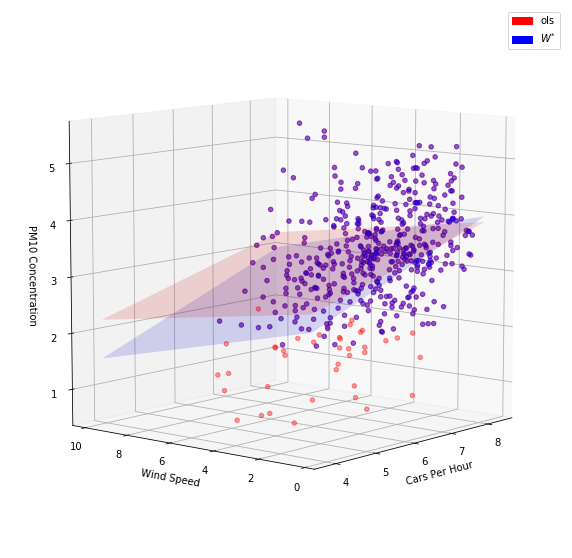

In [9]:
phi = oracle.Left(2.0)
indices = phi(y).flatten().nonzero(as_tuple=False).flatten()
x_trunc, y_trunc = X[indices], y[indices]
alpha = x_trunc.size(0) / X.size(0)
print("alpha: ", alpha)

trunc_ols = LinearRegression()
trunc_ols.fit(x_trunc, y_trunc) 
score = trunc_ols.score(X, y)
print("r^2: ", score)
emp_var = (y_trunc - trunc_ols.predict(x_trunc)).var(0)
print('empirical variance: ', float(emp_var))


fig = plt.figure(figsize=(10, 10))
ax = fig.gca(projection='3d')

x_max, x_min = X.max(0)[0], X.min(0)[0]
X_ = np.arange(x_min[0], x_max[0], .1)
Y = np.arange(x_min[1], x_max[1], .1)
X_, Y = np.meshgrid(X_, Y) 

with ch.no_grad():
    actual, emp = Tensor([]), Tensor([])
    for i in range(X_.shape[0]): 
        input_ = Tensor(np.hstack([X_[i].reshape(-1, 1), Y[i].reshape(-1, 1)]))
        emp = ch.cat([emp, Tensor(trunc_ols.predict(input_))], 1)
        actual = ch.cat([actual, Tensor(gt_ols.predict(input_))], 1)

    ax.plot_surface(X_, Y, emp.numpy().T, alpha=.15, color='red')
    ax.plot_surface(X_, Y, actual.numpy().T, alpha=.15, color='blue')
    
ax.scatter3D(X[:,0], X[:,1], y, color='red', label='entire dataset', alpha=.4)
ax.scatter3D(x_trunc[:,0], x_trunc[:,1], y_trunc, color='blue', label='S', alpha=.4)

emp_patch = mpatches.Patch(color='red', label='ols')
gt_patch = mpatches.Patch(color='blue', label="$W^{*}$")
plt.legend(handles=[emp_patch, gt_patch], loc="upper right")

ax.set_xlabel('Cars Per Hour')
ax.set_ylabel('Wind Speed')
ax.set_zlabel('PM10 Concentration')
    
ax.view_init(9.0, 220)

# Data Preprocessing
Now that we have our truncated dataset, then next thing that we have to do is run run our algorithm on the truncated data, and see if we can relieve some of the bias. Nevertheless, before doing that we want to do some feature engineering. 

First, we want to normalize our input features dataset. So, we divide all of our covariate features by $B\sqrt{k}$, so that $||x_{i}||_{2}^{2} \leq 1$, and reside on the $\ell_{2}$ ball. By doing this, the norm of $w$ will be multiplied by $B\sqrt{k}$.

Next, we want to standardize our dependent variable. We will do this by first substracting the mean of our dependent variable from each our dependent variables, and divide the standard deviation of the empirical noise variance. Our truncated dataset, will now have a dependent variable centered around the origin with a noise variance of 1. 

Since, we standardize our dependent variable, we next have to make sure to update our truncation set using the same standardization technique.

In [10]:
beta = LA.norm(x_trunc, dim=-1, ord=float('inf')).max()*math.sqrt(X.size(1))
x_trunc_norm = x_trunc / beta
x_norm = X / beta

We will first try to remove bias from the regression assuming that the noise variance of our untruncated dataset is the ground-truth noise variance of the linear regression problem. To do this, we standardize our dependent variable and other truncation set by the noise variance that we receive when we impose no truncation on our dataset. 

NOTE: since we normalize our input features and standardize our dependent variable, we need to make sure that reverse the applied transformation when our procedure is complete. To do this multiply our weight vector and intercept by the untruncated noise variance, we also divide our weight vector by our beta constant, and add the mean our truncated dependet variable to our intercept.

In [11]:
data = ch.linspace(0, 1.5, 100).reshape(-1, 1)

# scale wind by actual noise variance
y_trunc_mu = y_trunc.mean(0)
y_trunc_scaled = (y_trunc - y_trunc_mu) / ch.sqrt(gt_var)
y_scaled = (y - y_trunc_mu) / ch.sqrt(gt_var)

In [12]:
scaled_phi = oracle.Left((phi.left - y_trunc_mu) / ch.sqrt(gt_var))
known_trunc_reg = TruncatedRegression(phi=scaled_phi, alpha=Tensor([alpha]), lr=args.lr, unknown=args.unknown, bs=args.bs, n=args.n, tol=args.tol, steps=args.steps, val=args.n)
known_trunc_reg.fit(x_trunc_norm, y_trunc_scaled)
known_w, known_w0 = (known_trunc_reg.weight * ch.sqrt(gt_var)) / beta, known_trunc_reg.intercept * ch.sqrt(gt_var) + y_trunc_mu

Final Score: 0.006966555491089821


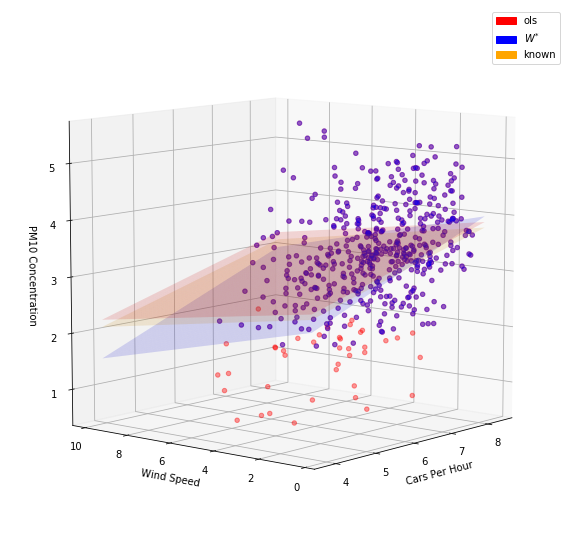

In [13]:
fig = plt.figure(figsize=(10, 10))
ax = fig.gca(projection='3d')

with ch.no_grad():
    known_pred = Tensor([])
    for i in range(X_.shape[0]): 
        input_ = Tensor(np.hstack([X_[i].reshape(-1, 1), Y[i].reshape(-1, 1)]))
        known_pred = ch.cat([known_pred, input_@known_w + known_w0], 1)

    ax.plot_surface(X_, Y, emp.numpy().T, alpha=.15, color='red')
    ax.plot_surface(X_, Y, actual.numpy().T, alpha=.15, color='blue')
    ax.plot_surface(X_, Y, known_pred.numpy().T, alpha=.15, color='orange')

ax.scatter3D(X[:,0], X[:,1], y, color='red', label='entire dataset', alpha=.4)
ax.scatter3D(x_trunc[:,0], x_trunc[:,1], y_trunc, color='blue', label='S', alpha=.4)
    
red_patch = mpatches.Patch(color='red', label='ols')

known_patch = mpatches.Patch(color='orange', label='known')
plt.legend(handles=[emp_patch, gt_patch, known_patch], loc="upper right")

ax.set_xlabel('Cars Per Hour')
ax.set_ylabel('Wind Speed')
ax.set_zlabel('PM10 Concentration')
    
ax.view_init(9.0, 220)

Now, we will try to remove bias from the regression without assuming that we know the noise variance. To do this, we standardize our dependent variable and other truncation set by the noise variance that we receive when we impose truncation on our dataset. We apply the same transformations to our dataset, as we do in the known variance case, but with a differnt standard deviation.

In [14]:
data = ch.linspace(0, 1.5, 100).reshape(-1, 1)

# scale wind by actual noise variance
y_trunc_mu = y_trunc.mean(0)
y_trunc_emp_scaled = (y_trunc - y_trunc_mu) / ch.sqrt(emp_var)
y_emp_scaled = (y - y_trunc_mu) / ch.sqrt(emp_var)

In [15]:
emp_scaled_phi = oracle.Left((phi.left - y_trunc_mu) / ch.sqrt(emp_var))
unknown_trunc_reg = TruncatedRegression(phi=emp_scaled_phi, alpha=Tensor([alpha]), unknown=True, lr=args.lr, step_lr_gamma=args.step_lr_gamma, bs=args.bs, n=args.n, tol=args.tol, steps=args.steps, val=args.n)
unknown_trunc_reg.fit(x_trunc_norm, y_trunc_emp_scaled)
w_, w0_ = (unknown_trunc_reg.weight * ch.sqrt(emp_var)) / beta, unknown_trunc_reg.intercept * ch.sqrt(emp_var) + y_trunc_mu

Iteration 1 | Score: 0.2771531641483307
Iteration 2 | Score: 0.2516939043998718
Iteration 3 | Score: 0.21853305399417877
Iteration 4 | Score: 0.19999362528324127
Iteration 5 | Score: 0.2758028507232666
Iteration 6 | Score: 0.23304152488708496
Iteration 7 | Score: 0.2387356013059616
Iteration 8 | Score: 0.2196638435125351
Iteration 9 | Score: 0.21051059663295746
Iteration 10 | Score: 0.24415189027786255
Iteration 11 | Score: 0.23261165618896484
Iteration 12 | Score: 0.21980825066566467
Iteration 13 | Score: 0.21797122061252594
Iteration 14 | Score: 0.24161657691001892
Iteration 15 | Score: 0.23493218421936035
Iteration 16 | Score: 0.2287198007106781
Iteration 17 | Score: 0.21801282465457916
Iteration 18 | Score: 0.23782357573509216
Iteration 19 | Score: 0.2218979448080063
Iteration 20 | Score: 0.2373560518026352
Iteration 21 | Score: 0.22048477828502655
Iteration 22 | Score: 0.21284374594688416
Iteration 23 | Score: 0.21907374262809753
Iteration 24 | Score: 0.22299335896968842
Iteration

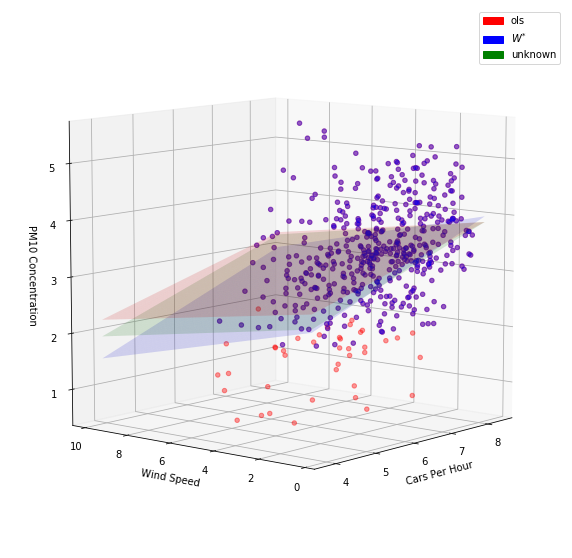

In [16]:
fig = plt.figure(figsize=(10, 10))
ax = fig.gca(projection='3d')

with ch.no_grad():
    unknown_pred = Tensor([])
    for i in range(X_.shape[0]): 
        input_ = Tensor(np.hstack([X_[i].reshape(-1, 1), Y[i].reshape(-1, 1)]))
        unknown_pred = ch.cat([unknown_pred, input_@w_ + w0_], 1)

    ax.plot_surface(X_, Y, emp.numpy().T, alpha=.15, color='red')
    ax.plot_surface(X_, Y, actual.numpy().T, alpha=.15, color='blue')
    ax.plot_surface(X_, Y, unknown_pred.numpy().T, alpha=.15, color='green')

ax.scatter3D(X[:,0], X[:,1], y, color='red', label='entire dataset', alpha=.4)
ax.scatter3D(x_trunc[:,0], x_trunc[:,1], y_trunc, color='blue', label='S', alpha=.4)
    
unknown_patch = mpatches.Patch(color='green', label='unknown')
plt.legend(handles=[emp_patch, gt_patch, unknown_patch], loc="upper right")

ax.set_xlabel('Cars Per Hour')
ax.set_ylabel('Wind Speed')
ax.set_zlabel('PM10 Concentration')
    
ax.view_init(9.0, 220)

In [17]:
unknown_params = ch.cat([w_, w0_]).flatten()
gt_params = Tensor(np.concatenate([gt_ols.coef_.flatten(), gt_ols.intercept_]))
trunc_ols_params = Tensor(np.concatenate([trunc_ols.coef_.flatten(), trunc_ols.intercept_]))
known_params = ch.cat([known_w.flatten(), known_w0.flatten()])

We now spawn a subprocess and run the same regression on truncreg.

In [18]:
# spawn subprocess to run truncreg experiment
concat = ch.cat([x_trunc, y_trunc], dim=1).numpy()

if not os.path.isdir(args.out_dir): 
    os.mkdir(args.out_dir)
"""
DATA FORMAT:
    -First n-1 columns are independent variables
    -nth column is dependent variable
"""
concat_df = pd.DataFrame(concat)
concat_df.to_csv(args.out_dir + '/' + TMP_FILE) # save data to csv
"""
Arguments
- c - truncation point (float)
- dir - left or right -> type of truncation (str)
"""
cmd = [COMMAND, PATH2SCRIPT] + [str(phi.left), str(x_trunc.size(1)), 'left', args.out_dir]

# check_output will run the command and store the result
st = datetime.datetime.now()
result = subprocess.check_output(cmd, universal_newlines=True)
trunc_res = Tensor(pd.read_csv(args.out_dir + '/' + RESULT_FILE)['x'].to_numpy())
trunc_reg_params = ch.cat([trunc_res[1:-1].flatten(), trunc_res[0][None,...]])

trunc_reg_pred = X@trunc_reg_params[:-1] + trunc_reg_params[-1]

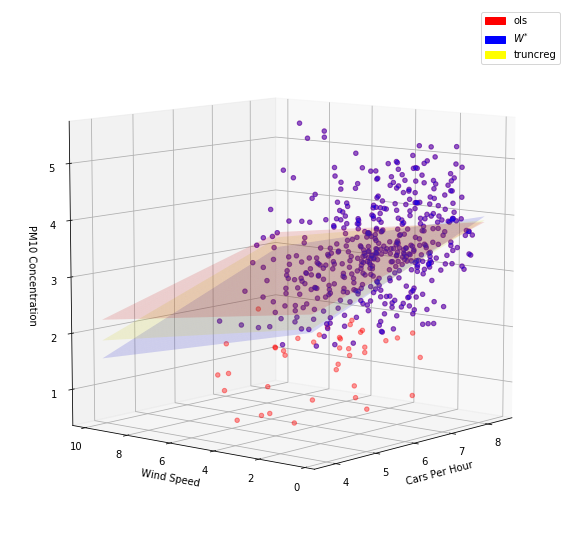

In [19]:
fig = plt.figure(figsize=(10, 10))
ax = fig.gca(projection='3d')

with ch.no_grad():
    truncreg_pred = Tensor([])
    for i in range(X_.shape[0]): 
        input_ = Tensor(np.hstack([X_[i].reshape(-1, 1), Y[i].reshape(-1, 1)]))
        truncreg_pred = ch.cat([truncreg_pred, (input_@trunc_reg_params[:-1] + trunc_reg_params[-1])[...,None]], 1)

    ax.plot_surface(X_, Y, emp.numpy().T, alpha=.15, color='red')
    ax.plot_surface(X_, Y, actual.numpy().T, alpha=.15, color='blue')
    ax.plot_surface(X_, Y, truncreg_pred.numpy().T, alpha=.15, color='yellow')

ax.scatter3D(X[:,0], X[:,1], y, color='red', label='entire dataset', alpha=.4)
ax.scatter3D(x_trunc[:,0], x_trunc[:,1], y_trunc, color='blue', label='S', alpha=.4)
    
truncreg_patch = mpatches.Patch(color='yellow', label='truncreg')
plt.legend(handles=[emp_patch, gt_patch, truncreg_patch], loc="upper right")

ax.set_xlabel('Cars Per Hour')
ax.set_ylabel('Wind Speed')
ax.set_zlabel('PM10 Concentration')
    
ax.view_init(9.0, 220)

We now plot all of the estimates on the figure to see how the various estimation techniques compare. We show that all three techniques removes bias from the original biased OLS estiamtes. 

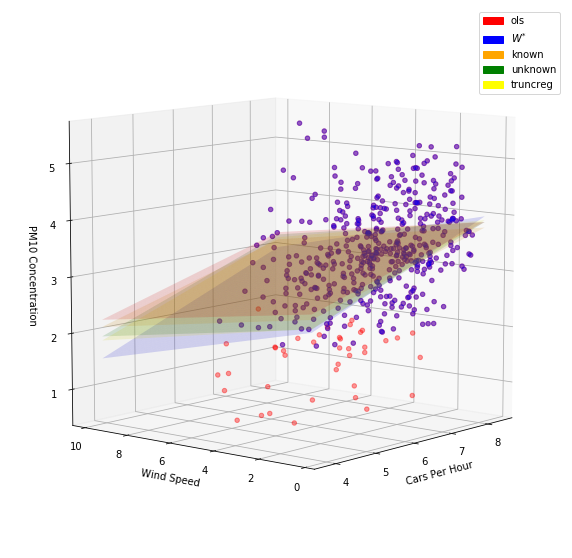

In [20]:
fig = plt.figure(figsize=(10, 10))
ax = fig.gca(projection='3d')

ax.plot_surface(X_, Y, emp.numpy().T, alpha=.15, color='red')
ax.plot_surface(X_, Y, actual.numpy().T, alpha=.15, color='blue')
ax.plot_surface(X_, Y, truncreg_pred.numpy().T, alpha=.15, color='yellow')
ax.plot_surface(X_, Y, unknown_pred.numpy().T, alpha=.15, color='green')
ax.plot_surface(X_, Y, known_pred.numpy().T, alpha=.15, color='orange')

ax.scatter3D(X[:,0], X[:,1], y, color='red', label='entire dataset', alpha=.4)
ax.scatter3D(x_trunc[:,0], x_trunc[:,1], y_trunc, color='blue', label='S', alpha=.4)
    

plt.legend(handles=[emp_patch, gt_patch, known_patch, unknown_patch, truncreg_patch], loc="upper right")

ax.set_xlabel('Cars Per Hour')
ax.set_ylabel('Wind Speed')
ax.set_zlabel('PM10 Concentration')
    
ax.view_init(9.0, 220)

# Create Store for Experiment Results

In [7]:
def run_trial(kwargs, X, y, tol, attempts):
    """
    Runs a trial of a truncated regression experiment. Runs a maximum 
    of three trials of an experiment. The experiment terminates when either 
    the norm of teh score is less than 3e-1, or when three trials is up. After 
    three trials it returns the best truncated regression experiment.
    :param kwargs: keyword arguments for experiment 
    :param X: independent variable
    :param y: dependent variable
    :return: truncated regression experiment and time that experiment took
    """
    st = datetime.datetime.now()        
    # run procedure until get reasonable score
    attempt, score, best_trunc_reg = 0, None, None
    while (score is None or score.norm() > tol) and attempt < attempts:
        trunc_reg = TruncatedRegression(**kwargs)
        trunc_reg.fit(X, y)
        grad = trunc_reg.score()
        if score is None or grad.norm() < score.norm(): 
            score, best_trunc_reg = grad, trunc_reg
        attempt += 1
    total_time = int((datetime.datetime.now() - st).total_seconds())
    return best_trunc_reg, total_time   

# Run Procedure
Now, we will run 20 trials of trying to retrieve the underlying untruncaed regression on the regression task presented above.

In [ ]:
# ground_truth parameters
gt = LinearRegression() 
gt.fit(X, y)
gt_params = Tensor(np.concatenate([gt.coef_.flatten() ,gt.intercept_]))
gt_var = Tensor(np.var(gt.predict(X) - y.numpy(), 0))

# variables for tracking best and worst trials

C = [1, 1.5, 2.0, 2.25, 2.5, 2.75, 3.0, 3.25, 3.5, 4.0]
for i in range(args.trials):
    # create store
    store = Store(args.out_dir + '/' + args.exp)
    store.add_table(TABLE_NAME, { 
        'known_r2': float,
        'known_param_mse': float,
        'known_time': int,
        'known_score': float,
        'unknown_param_mse': float,
        'unknown_var_l1': float,
        'unknown_r2': float,
        'unknown_time': int,
        'unknown_score': float,
        'ols_r2': float, 
        'ols_param_mse': float,
        'ols_var_l1': float,
        'trunc_reg_param_mse': float, 
        'trunc_reg_var_l1': float,
        'trunc_reg_r2': float,
        'trunc_reg_time': int,
        'alpha': float, 
        'c': float, 
        'num_samples': int,
    })
    
    for c in C: 
        # truncate
        phi = oracle.Left(c)
        indices = phi(y).flatten().nonzero(as_tuple=False).flatten()
        x_trunc, y_trunc = X[indices], y[indices]
        # add survival probability to hyperparameters
        alpha = Tensor([x_trunc.size(0) / X.size(0)])
        
        y_trunc_mu = y_trunc.mean(0)
        
        # empirical linear regression
        ols = LinearRegression() 
        ols.fit(x_trunc, y_trunc)
        emp_noise_var = ch.var(Tensor(ols.predict(x_trunc)) - y_trunc, dim=0)[...,None]
        ols_params = ch.cat([Tensor(ols.coef_).T, Tensor(ols.intercept_)[..., None]]).flatten()
        print("c: ", c)

        # ols results
        store[TABLE_NAME].update_row({
            'ols_r2': r2_score(y.flatten(), ols.predict(X).flatten()), 
            'ols_var_l1': ch.abs(emp_noise_var - gt_var),
            'ols_param_mse': mse_loss(ols_params, gt_params),
        })
        val = int(args.val*x_trunc.size(0))
        
        # normalize input data, so that assumption for algorithm is satisfied
        beta = LA.norm(x_trunc, dim=-1, ord=float('inf')).max()*math.sqrt(X.size(1))
        x_trunc_norm = x_trunc / beta
        
        # scale by the known noise variance 
        y_trunc_scaled = (y_trunc - y_trunc_mu) / ch.sqrt(gt_var)
        phi_scaled = oracle.Left((phi.left - y_trunc_mu) / ch.sqrt(gt_var))
        
        # standardize noised by actual noise variance
        known_kwargs = { 
            'phi': phi_scaled, 
            'alpha': alpha, 
            'bias': args.bias, 
            'unknown': False, 
            'bs': args.bs, 
            'n': args.n, 
            'tol': args.tol, 
            'steps': args.steps, 
            'step_lr': args.step_lr, 
            'step_lr_gamma': args.step_lr_gamma,
            'val': val
        }
        
        # truncated linear regression with known noise variance using empirical noise variance
        known_trunc_reg, total_time = run_trial(known_kwargs, x_trunc_norm, y_trunc_scaled, args.tol, args.attempts) 
        
        w, w0 = (known_trunc_reg.weight * ch.sqrt(gt_var)) / beta, known_trunc_reg.intercept * ch.sqrt(gt_var) + y_trunc_mu 
        known_params = ch.cat([w.flatten(), w0])
        # known results
        store[TABLE_NAME].update_row({
            'known_r2': r2_score(y.flatten(), X@w + w0), 
            'known_param_mse': mse_loss(known_params, gt_params),
            'known_time': total_time, 
            'known_score': known_trunc_reg.score(),
        })
        
        
        phi_emp_scaled = oracle.Left((phi.left - y_trunc_mu) / ch.sqrt(emp_noise_var))
        y_trunc_emp_scaled = (y_trunc - y_trunc_mu) / ch.sqrt(emp_noise_var)
            
        # standardize noised by actual noise variance
        unknown_kwargs = { 
            'phi': phi_emp_scaled, 
            'alpha': alpha, 
            'bias': args.bias, 
            'unknown': True, 
            'bs': args.bs, 
            'n': args.n, 
            'tol': args.tol, 
            'steps': args.steps, 
            'step_lr': args.step_lr, 
            'step_lr_gamma': args.step_lr_gamma,
            'val': val
        }
        
        # truncated linear regression with unknown noise variance using empirical noise variance
        unknown_trunc_reg, total_time = run_trial(unknown_kwargs, x_trunc_norm, y_trunc_emp_scaled, args.tol, args.attempts)  
        
        w, w0 = (unknown_trunc_reg.weight * ch.sqrt(emp_noise_var)) / beta, unknown_trunc_reg.intercept * ch.sqrt(emp_noise_var) + y_trunc_mu
        unknown_params = ch.cat([w.flatten(), w0.flatten()])
        # known results
        store[TABLE_NAME].update_row({
            'unknown_r2': r2_score(y.flatten(), X@w + w0), 
            'unknown_param_mse': mse_loss(unknown_params, gt_params),
            'unknown_time': total_time, 
            'unknown_var_l1': ch.abs(unknown_trunc_reg.variance * emp_noise_var - gt_var),
            'unknown_score': unknown_trunc_reg.score()
        })
            
        # spawn subprocess to run truncreg experiment
        concat = ch.cat([x_trunc, y_trunc], dim=1).numpy()
        """
        DATA FORMAT:
            -First n-1 columns are independent variables
            -nth column is dependent variable
        """
        concat_df = pd.DataFrame(concat)
        concat_df.to_csv(args.out_dir + '/' + TMP_FILE) # save data to csv
        """
        Arguments
        - c - truncation point (float)
        - dir - left or right -> type of truncation (str)
        """
        cmd = [COMMAND, PATH2SCRIPT] + [str(c), str(x_trunc.size(1)), 'left', args.out_dir]

        # check_output will run the command and store the result
        st = datetime.datetime.now()
        result = subprocess.check_output(cmd, universal_newlines=True)
        trunc_res = Tensor(pd.read_csv(args.out_dir + '/' + RESULT_FILE)['x'].to_numpy())
        trunc_reg_params = ch.cat([trunc_res[1:-1].flatten(), trunc_res[0][None,...]])

        trunc_reg_pred = X@trunc_reg_params[:-1] + trunc_reg_params[-1]
        
        # truncreg results
        store[TABLE_NAME].update_row({
            'trunc_reg_r2': r2_score(y.flatten(), trunc_reg_pred.flatten()), 
            'trunc_reg_param_mse': mse_loss(trunc_reg_params, gt_params),
            'trunc_reg_var_l1': ch.abs(trunc_res[-1].pow(2)[None,...] - gt_var),
            'trunc_reg_time': int((datetime.datetime.now() - st).total_seconds()), 
            })   

        store[TABLE_NAME].append_row({ 
            'alpha': float(alpha), 
            'c': c,    
            'num_samples': x_trunc.size(0),
        })
        
        IPython.display.clear_output()
            
    # close current store
    store.close()

c:  2.0
Iteration 1 | Score: 0.0773741602897644
Iteration 2 | Score: 0.06661535799503326
Iteration 3 | Score: 0.047944292426109314
Iteration 4 | Score: 0.06821643561124802
Iteration 5 | Score: 0.06323090195655823
Iteration 6 | Score: 0.04438766837120056
Iteration 7 | Score: 0.08250761032104492
Iteration 8 | Score: 0.06862451136112213
Iteration 9 | Score: 0.04610570892691612
Iteration 10 | Score: 0.07224059849977493
Iteration 11 | Score: 0.06217877194285393
Iteration 12 | Score: 0.05616536736488342
Iteration 13 | Score: 0.05771186947822571
Iteration 14 | Score: 0.05778560787439346
Iteration 15 | Score: 0.05366628244519234
Iteration 16 | Score: 0.058453649282455444
Iteration 17 | Score: 0.06701426953077316
Iteration 18 | Score: 0.05298513174057007
Iteration 19 | Score: 0.07354240119457245
Iteration 20 | Score: 0.06764374673366547
Iteration 21 | Score: 0.06320445239543915
Iteration 22 | Score: 0.047569241374731064
Iteration 23 | Score: 0.06740538030862808
Iteration 24 | Score: 0.082344599

# Results

In [50]:
reader = CollectionReader(args.out_dir + '/' + args.exp)
logs = reader.df(TABLE_NAME)
logs.head()

  0%|          | 0/7 [00:00<?, ?it/s]


ValueError: The file '/Users/patroklos/Desktop/pm10_bs_100/RunAgain/ace2168c-1de2-46e0-8018-16521f1b846d/store.h5' is already opened, but not in read-only mode (as requested).

# Remove the Best and the Worst Trials for Each Truncation Parameter C from the Result Logs

In [33]:
cols = ['unknown_param_mse', 'unknown_var_l1', 'unknown_r2', 'unknown_score', 'c', 'alpha']
unknown_logs = pd.DataFrame(columns=cols)
for c in C: 
    temp = logs[logs['c'] == c][cols].reset_index()
    temp = temp[temp.unknown_score == temp.unknown_score.min()]

    unknown_logs = pd.concat([unknown_logs, temp], sort=True)
unknown_logs = unknown_logs.reset_index()

In [34]:
cols = ['known_param_mse', 'c', 'known_r2', 'known_score', 'alpha']
known_logs = pd.DataFrame(columns=cols)
for c in C: 
    temp = logs[logs['c'] == c][cols].reset_index()
    temp = temp[temp.known_score == temp.known_score.min()]
    known_logs = pd.concat([known_logs, temp], sort=True)
known_logs = known_logs.reset_index()

In [35]:
cols = ['trunc_reg_param_mse', 'trunc_reg_var_l1', 'trunc_reg_r2', 'c', 'alpha']
truncreg_logs = pd.DataFrame(columns=cols)
for c in C: 
    temp = logs[logs['c'] == c][cols].reset_index()
    temp.drop(index=temp[['trunc_reg_param_mse', 'trunc_reg_var_l1']].sum(1).idxmax(), inplace=True)
    temp.drop(index=temp[['trunc_reg_param_mse', 'trunc_reg_var_l1']].sum(1).idxmin(), inplace=True)
    truncreg_logs = pd.concat([truncreg_logs, temp], sort=True)
truncreg_logs = truncreg_logs.reset_index()

# Plot Results

In [36]:
unknown_logs['unknown_param_mse'] = unknown_logs['unknown_param_mse'] ** (.5)
known_logs['known_param_mse'] = known_logs['known_param_mse'] ** (.5)
truncreg_logs['trunc_reg_param_mse'] = truncreg_logs['trunc_reg_param_mse'] ** (.5)
logs['ols_param_mse'] = logs['ols_param_mse'] ** (.5)

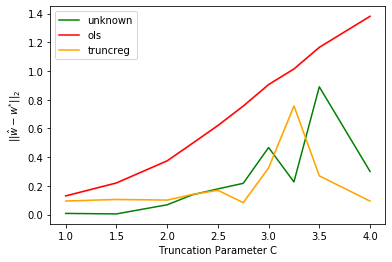

In [37]:
# plot results for regression parameter MSE
sns.lineplot(data=unknown_logs, x='c', y='unknown_param_mse', label='unknown', color='green')
# sns.lineplot(data=known_logs, x='c', y='known_param_mse', color='blue', label='known')
sns.lineplot(data=logs, x='c', y='ols_param_mse', label='ols', color='red')
sns.lineplot(data=truncreg_logs, x='c', y='trunc_reg_param_mse', label='truncreg', color='orange')
plt.xlabel('Truncation Parameter C')
plt.ylabel('$||\hat w - w^{*}||_{2}$')
plt.show()

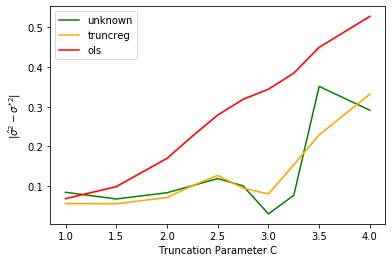

In [38]:
# plot results for regression noise variance MSE
sns.lineplot(data=unknown_logs, x='c', y='unknown_var_l1', label='unknown', color="green")
sns.lineplot(data=truncreg_logs, x='c', y='trunc_reg_var_l1', label='truncreg', color='orange')
ax = sns.lineplot(data=logs, x='c', y='ols_var_l1', label='ols', color="red")
plt.xlabel('Truncation Parameter C')
plt.ylabel('$|\hat \sigma^{2} - \sigma^{*2}|$')
plt.show()

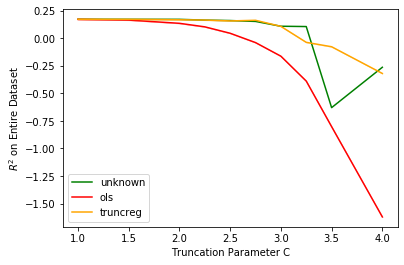

In [39]:
# plot results for regression parameter MSE
# sns.lineplot(data=known_logs, x='c', y='known_r2', label='known', color='blue')
sns.lineplot(data=unknown_logs, x='c', y='unknown_r2', label='unknown', color='green')
sns.lineplot(data=logs, x='c', y='ols_r2', label='ols', color='red')
sns.lineplot(data=truncreg_logs, x='c', y='trunc_reg_r2', label='truncreg', color='orange')
plt.xlabel('Truncation Parameter C')
plt.ylabel('$R^{2}$ on Entire Dataset')
plt.show()

In [40]:
unknown_logs['epsilon'] = unknown_logs['unknown_param_mse'] + unknown_logs['unknown_var_l1']
known_logs['epsilon'] = known_logs['known_param_mse']
truncreg_logs['epsilon'] = truncreg_logs['trunc_reg_param_mse'] + truncreg_logs['trunc_reg_var_l1']
logs['ols_epsilon'] = logs['ols_param_mse'] + logs['ols_var_l1']

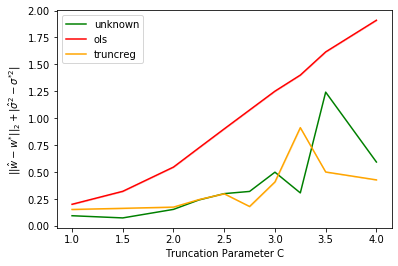

In [41]:
# plot results for regression parameter MSE
sns.lineplot(data=unknown_logs, x='c', y='epsilon', label='unknown', color='green')
# sns.lineplot(data=known_logs, x='c', y='epsilon', color='blue', label='known')
sns.lineplot(data=logs, x='c', y='ols_epsilon', label='ols', color='red')
sns.lineplot(data=truncreg_logs, x='c', y='epsilon', label='truncreg', color='orange')
plt.xlabel('Truncation Parameter C')
plt.ylabel('$||\hat w - w^{*}||_{2} + |\hat \sigma^{2} - \sigma^{*2}|$')
plt.show()

In [44]:
logs[logs.c == 3.0].alpha

6    0.66
6    0.66
6    0.66
6    0.66
6    0.66
6    0.66
6    0.66
6    0.66
6    0.66
6    0.66
Name: alpha, dtype: float64

In [45]:
logs[logs.c == 3.25].alpha

7    0.532
7    0.532
7    0.532
7    0.532
7    0.532
7    0.532
7    0.532
7    0.532
7    0.532
7    0.532
Name: alpha, dtype: float64

In [46]:
logs[logs.c == 3.5].alpha

8    0.376
8    0.376
8    0.376
8    0.376
8    0.376
8    0.376
8    0.376
8    0.376
8    0.376
8    0.376
Name: alpha, dtype: float64

In [47]:
logs[logs.c == 4.0].alpha

9    0.208
9    0.208
9    0.208
9    0.208
9    0.208
9    0.208
9    0.208
9    0.208
9    0.208
9    0.208
Name: alpha, dtype: float64